<a href="https://colab.research.google.com/github/Yassmina-Abdo/natural-language-processing/blob/main/news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective:
- The objective from this task is to use your NLP skills to build a ML model can <b>classify the news categories</b>.
- Try hard to get the maximum value of the preferable evaluation metric using any technique.
- <b>Concat headlines and short descriptions</b> and use them in classification. 

### Time:
- This task mustn't take more than <b>3 hours</b>.
    - Load Data and EDA : 30 minutes
    - Cleaning and Preprocessing : 60 Minutes
    - Modelling and Enhancement : 60 Minutes
    - Extratime : 30 minutes

### Fixed Rules:
- train test split 80% : 20%
- all random seeds = 42

# Delivery:
## Through this [form](https://forms.gle/PshJQw2bTa48Ligz7)

> ### Take a deep breath, read the instructions again, and then start

## Load Libraries

In [1]:
!pip install contractions --q

In [51]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn import metrics
import contractions
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import casual_tokenize, word_tokenize
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras import models,layers
from tensorflow.keras import optimizers
import re

## Load Dataset

In [3]:
data = [json.loads(line) for line in open('Dataset.json', 'r')]

In [4]:
# convert to data frame
df= pd.DataFrame(data)
df.sample(5)

,category,headline,authors,link,short_description,date
118911,HEALTHY LIVING,"This Total-Body Workout Will Fly By, Thanks To...","SELF, Contributor",https://www.huffingtonpost.com/entry/health-an...,This fitness routine will make your session fl...,2014-06-28
9142,POLITICS,The GOP's Tax Bill Kicks Puerto Rico When It's...,Jennifer Bendery,https://www.huffingtonpost.com/entry/puerto-ri...,The island is getting slapped with new taxes a...,2017-12-20
167941,WELLNESS,Spirit of Help,"Maggie Lyon, Contributor\nWriter on wellness a...",https://www.huffingtonpost.com/entry/self-help...,"In taking a leavened, eyes-open view of our co...",2013-01-17
105912,STYLE,"Thanks Rihanna, Now We Want THIS Lipstick Color",Dana Oliver,https://www.huffingtonpost.com/entry/rihanna-l...,,2014-11-23
70896,POLITICS,Catholic Newspaper Names Same-Sex Marriage Pla...,Amanda Terkel,https://www.huffingtonpost.com/entry/catholic-...,"Last year, it was the pope.",2015-12-28


## EDA

In [5]:
#check duplicate
print(df.duplicated().sum())

13


In [6]:
df=df.drop_duplicates()

In [7]:
df.shape

(200840, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200840 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200840 non-null  object
 1   headline           200840 non-null  object
 2   authors            200840 non-null  object
 3   link               200840 non-null  object
 4   short_description  200840 non-null  object
 5   date               200840 non-null  object
dtypes: object(6)
memory usage: 10.7+ MB


In [9]:
df['category'].value_counts()  #41 class

POLITICS          32738
WELLNESS          17824
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9646
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3489
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2078
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1322
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

## Cleaning & Preprocessing

**Replace Same Category**

In [10]:
def category_cleaner(x):
    if x == 'THE WORLDPOST':
        return 'WORLDPOST'
    elif x == 'PARENTING':
        return 'PARENTS'
    elif x == 'ARTS' or x == 'CULTURE & ARTS':
        return 'ARTS & CULTURE'
    elif x == 'STYLE':
        return 'STYLE & BEAUTY'
    elif x == 'COLLEGE':
        return 'EDUCATION'
    elif x == 'TASTE':
        return 'FOOD & DRINK'
    else:
        return x
    
df['category'] = df.category.apply(category_cleaner)

In [11]:
#check
len(df['category'].value_counts())  

34

**Encode Category col**

In [12]:
df['CategoryId'] = df['category'].factorize()[0]
df.sample(3)

,category,headline,authors,link,short_description,date,CategoryId
3294,ENTERTAINMENT,Steven Spielberg Says Netflix Films Shouldn't ...,Ron Dicker,https://www.huffingtonpost.com/entry/steven-sp...,"""You're a TV movie,"" the 71-year-old legend said.",2018-03-26,1
193977,TRAVEL,"Essential Road Trip Songs, As Picked By Reader...",,https://www.huffingtonpost.com/entry/essential...,We here at Huffington Post Travel love us a ro...,2012-04-11,12
53315,FOOD & DRINK,7 Ways We All Need To Use Less Plastic Wrap In...,Julie R. Thomson,https://www.huffingtonpost.com/entry/plastic-w...,Put the plastic wrap down.,2016-07-15,23


**Combine columns**

In [13]:
#Combining Title and Description --- >
df['content']= df['headline']+' '+df['short_description']

In [14]:
df['content'].sample(5)

57146     Texas Builds A Wildlife Highway To Help Endang...
36146     Honey Boo Boo's Mother Is Back On Reality TV T...
82397     Caitlyn Jenner Could Be Charged With Vehicular...
185578    Is It Possible to Try Too Hard? We've heard it...
121052    Back from the Valley: Sebastian Junger on Kore...
Name: content, dtype: object

**preprocessing applied on content column**

In [15]:
def preprocess(text): 
  text = text.lower() #1.lower
  text= contractions.fix(text)  #2.contractions 
  text=  re.sub(r'[^\w\s]', '',  text)   #4. punc
  return text

df['content'] = df['content'].apply(lambda x: preprocess(x))     

In [16]:
#check
df['content'].sample(5)

12027     what my mothers weight struggle taught me abou...
113452            terri j vaughn talks girlfriends getaway 
74391     daily news compares nra to jihadists on front ...
93402     women in business qa victoria tkacheva directo...
84745     who is esteban oliverez new 2016 gop president...
Name: content, dtype: object

**check**

In [17]:
df.sample(3)

,category,headline,authors,link,short_description,date,CategoryId,content
32700,BLACK VOICES,Apathy & Complacency: How We Got A Flamin' Hot...,"Kaylin Dodson, ContributorWriter, Student, You...",https://www.huffingtonpost.com/entry/apathy-co...,"In our complacency, we had no fear of a puffed...",2017-03-05,6,apathy complacency how we got a flamin hot ch...
9313,BUSINESS,ESPN President John Skipper Resigns Unexpectedly,Ryan Grenoble,https://www.huffingtonpost.com/entry/john-skip...,Skipper cited substance addiction in a statement.,2017-12-18,11,espn president john skipper resigns unexpected...
171889,WELLNESS,NIH and Superbugs: Placing the Blame Where It ...,"Dr. Lisa K. Fitzpatrick, MD, MPH, MPA, Contrib...",https://www.huffingtonpost.com/entry/superbugs...,The emergence of multi-drug-resistant bacteria...,2012-12-05,28,nih and superbugs placing the blame where it b...


**TF-IDF**

In [33]:
vec = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), min_df=.01, max_df=.3)
X = vec.fit_transform(df['content'])
X_train, X_test, y_train, y_test = train_test_split(X, df['CategoryId'], train_size= 0.8, random_state=42, shuffle= True)

## Modelling



*   **Logistic Regression**



In [37]:
lr = LogisticRegression(solver='saga',multi_class='multinomial', max_iter=50, C=1,random_state=42)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

In [67]:
print("Accuracy %.3f" %metrics.accuracy_score(y_test, y_predict))

Accuracy 0.569


## Enhancement

**Tokenizer**

In [42]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df['content'].values)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % len(word_index))

Found 114554 unique tokens.


In [44]:
X = tokenizer.texts_to_sequences(df['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (200840, 250)


In [45]:
Y = df['CategoryId'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (200840,)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(160672, 250) (160672,)
(40168, 250) (40168,)


* **LSTM**

In [61]:
model = tf.keras.models.Sequential()
model.add(layers.Embedding(vocab_size, 128, mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(34, activation='softmax'))

In [62]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=2, batch_size=512,validation_split=0.2,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/2
252/252 [==============================] - 302s 1s/step - loss: 1.9226 - accuracy: 0.4900 - val_loss: 1.3563 - val_accuracy: 0.6314
Epoch 2/2
252/252 [==============================] - 306s 1s/step - loss: 1.1020 - accuracy: 0.6904 - val_loss: 1.2612 - val_accuracy: 0.6559


## Final Results and Conclusion

* **Logistic Regression Result**

In [68]:
print(classification_report(y_test,y_predict ))

              precision    recall  f1-score   support

           0       0.51      0.46      0.49       683
           1       0.48      0.68      0.56      3117
           2       0.44      0.11      0.18       427
           3       0.33      0.17      0.23       716
           4       0.62      0.81      0.70      6533
           5       0.33      0.16      0.21       534
           6       0.46      0.28      0.35       860
           7       0.42      0.26      0.32       744
           8       0.51      0.29      0.37      1070
           9       0.68      0.55      0.60      1284
          10       0.58      0.51      0.54       980
          11       0.45      0.36      0.40      1198
          12       0.63      0.69      0.66      1971
          13       0.50      0.27      0.35       552
          14       0.53      0.32      0.40       440
          15       0.57      0.36      0.44       519
          16       0.61      0.34      0.43       466
          17       0.65    

* **LSTM Result**

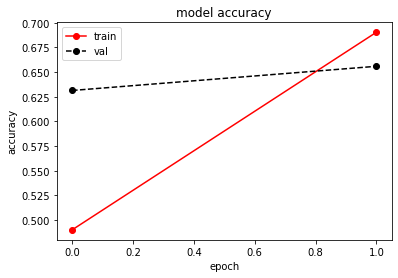

In [65]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'],'r-o')
plt.plot(history.history['val_accuracy'],'k--o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

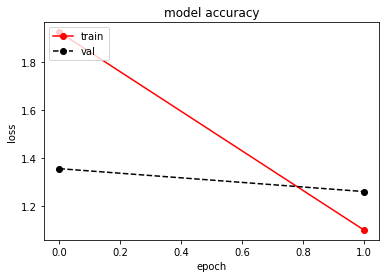

In [66]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],'r-o')
plt.plot(history.history['val_loss'],'k--o')
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Best Wishes


## Again: Delivery through this [form](https://forms.gle/PshJQw2bTa48Ligz7)